## Analyzing with property rows

In [73]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

rental_data = pd.read_csv('../data/processed/cleaned_rental_data_with_postalcode.csv')
crime_data = pd.read_csv('../data/processed/crime_with_postalcode_cityname.csv')
print(f"The length of dataframe: {len(rental_data)}")
print(f"The length of dataframe: {len(crime_data)}")

The length of dataframe: 6521
The length of dataframe: 29452


### Try with "postal_code"

In [74]:
# rental_data = rental_data[rental_data['city_name'] == 'Los Angeles']
crime_agg = crime_data.groupby('postal_code').size().reset_index(name='crime_count')

In [75]:
avg_total_security = rental_data.groupby('postal_code')['total_security_amenities'].mean().reset_index()
avg_total_security.rename(columns={'total_security_amenities': 'avg_total_security_amenities'}, inplace=True)

In [76]:
merged_data = pd.merge(avg_total_security, crime_agg, on='postal_code', how='left')
merged_data['crime_count'] = merged_data['crime_count'].fillna(0)
# merged_data

In [77]:
merged_data['high_crime'] = (merged_data['crime_count'] > merged_data['crime_count'].median()).astype(int)
merged_data

,postal_code,avg_total_security_amenities,crime_count,high_crime
0,90001,0.000000,106.0,1
1,90002,0.333333,389.0,1
2,90003,0.347826,793.0,1
3,90004,2.250000,527.0,1
4,90005,2.466667,312.0,1
...,...,...,...,...
205,93536,0.274194,0.0,0
206,93550,0.476923,0.0,0
207,93551,0.185185,0.0,0
208,93552,0.388889,0.0,0


In [78]:
amenity_columns = rental_data.loc[:, 'security':'patrol'].columns
amenity_count = rental_data.groupby('postal_code')[amenity_columns].sum().reset_index()

In [79]:
merged_data = pd.merge(merged_data, amenity_count, on='postal_code', how='left')
merged_data

,postal_code,avg_total_security_amenities,crime_count,high_crime,security,gated,surveillance,camera,alarm,guard,...,access control,security system,electronic locks,monitoring,fenced,safe,locked,protected,secure entry,patrol
0,90001,0.000000,106.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,90002,0.333333,389.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,90003,0.347826,793.0,1,0,4,0,0,0,0,...,0,0,0,0,4,0,0,0,0,0
3,90004,2.250000,527.0,1,16,15,0,1,0,0,...,0,0,0,1,2,0,0,0,0,1
4,90005,2.466667,312.0,1,14,22,0,0,0,0,...,1,0,0,0,1,2,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,93536,0.274194,0.0,0,6,3,0,0,0,0,...,0,0,0,0,4,0,0,0,0,1
206,93550,0.476923,0.0,0,10,12,1,0,0,0,...,0,0,0,0,4,0,0,0,0,2
207,93551,0.185185,0.0,0,0,3,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
208,93552,0.388889,0.0,0,0,3,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1


#### To analyze if high-crime neighborhoods have a higher prevalence of safety-focused amenities:

In [80]:
X = merged_data[['avg_total_security_amenities']].fillna(0)  # Features
y = merged_data['high_crime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(f"Coefficient for Total Security Amenities: {log_reg.coef_[0][0]}")
print(f"Intercept: {log_reg.intercept_[0]}")
print(f"The length of dataframe: {len(merged_data)}")

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        27
           1       0.70      0.47      0.56        15

    accuracy                           0.74        42
   macro avg       0.72      0.68      0.69        42
weighted avg       0.73      0.74      0.72        42

Coefficient for Total Security Amenities: 0.9915187043894681
Intercept: -0.7969896350018245
The length of dataframe: 210


#### To identify crime thresholds influencing safety amenities:

In [81]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score

# Define features and target
X = merged_data[['crime_count']].fillna(0)
y = (merged_data['avg_total_security_amenities'] > 2).astype(int)  # Target: presence of safety amenities

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree Classifier
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# Evaluate and visualize
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree)}")
print(export_text(tree, feature_names=['crime_count']))
print(f"The length of dataframe: {len(merged_data)}")

Accuracy: 0.9523809523809523
|--- crime_count <= 798.00
|   |--- crime_count <= 68.00
|   |   |--- crime_count <= 0.50
|   |   |   |--- class: 0
|   |   |--- crime_count >  0.50
|   |   |   |--- class: 0
|   |--- crime_count >  68.00
|   |   |--- crime_count <= 345.00
|   |   |   |--- class: 0
|   |   |--- crime_count >  345.00
|   |   |   |--- class: 0
|--- crime_count >  798.00
|   |--- crime_count <= 972.00
|   |   |--- crime_count <= 880.00
|   |   |   |--- class: 1
|   |   |--- crime_count >  880.00
|   |   |   |--- class: 0
|   |--- crime_count >  972.00
|   |   |--- class: 1

The length of dataframe: 210


In [82]:
# from sklearn.tree import export_graphviz
# import graphviz

# # Export the decision tree to a DOT file
# dot_data = export_graphviz(
#     tree,  # Replace with your decision tree model
#     out_file=None,
#     feature_names=['crime_count'],  # Replace with your feature names
#     class_names=['Low Average Security Amenities', 'High Average Security Amenities'],
#     filled=True,
#     rounded=True,
#     special_characters=True
# )

# # Render the DOT file
# graph = graphviz.Source(dot_data)
# graph.render("decision_tree")  # Saves the tree as 'decision_tree.pdf'
# graph.view()  # Opens the rendered PDF

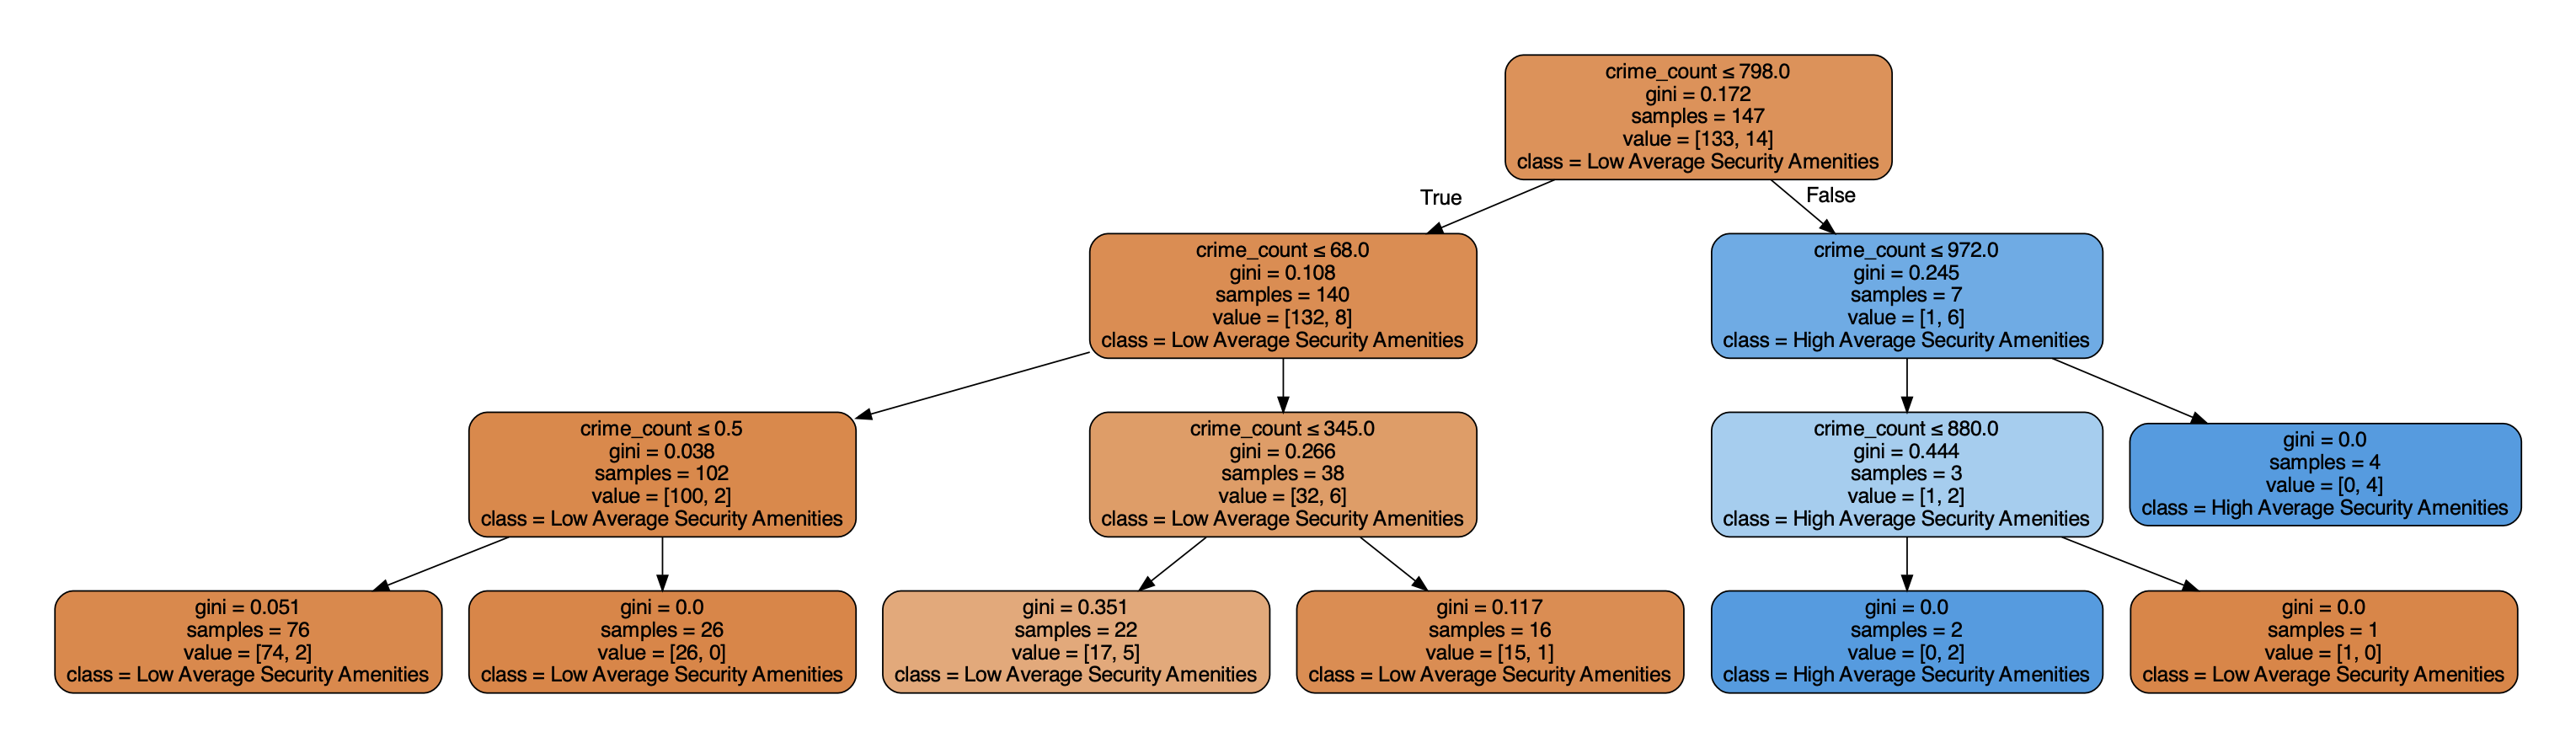

#### Crime count in High-crime area vs avg_total_security_amenities

In [83]:
merged_data['high_crime'] = (merged_data['crime_count'] > merged_data['crime_count'].median()).astype(int)
high_crime_data = merged_data[merged_data['high_crime'] == 1]
# high_crime_data 

In [84]:
X = high_crime_data[['crime_count']]
y = high_crime_data['avg_total_security_amenities']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [85]:
import numpy as np

Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
# Identify the indices of outliers
outlier_indices = y[(y < lower_bound) | (y > upper_bound)].index

# Get the removed rows
removed_rows = X.loc[outlier_indices]
removed_targets = y.loc[outlier_indices]

# Print outlier information
print(f"Outlier Indices: {outlier_indices.tolist()}")
print(f"Removed Rows:\n{removed_rows}")
print(f"Removed Target Values:\n{removed_targets}")

# Optionally save the removed rows to a file for future reference
removed_data = pd.concat([removed_rows, removed_targets], axis=1)
removed_data.to_csv("removed_outliers.csv", index=True)

# Remove rows where y contains outliers
non_outliers = (y >= lower_bound) & (y <= upper_bound)
X_no_outliers = X[non_outliers]
y_no_outliers = y[non_outliers]
filtered_data = pd.concat([X_no_outliers, y_no_outliers], axis=1)
print(f"Number of rows after removing outliers: {len(y)}, {len(y_no_outliers)}")

# Split the data again after outlier removal
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.3, random_state=42)

Outlier Indices: [11, 15, 51]
Removed Rows:
    crime_count
11        994.0
15        787.0
51        342.0
Removed Target Values:
11    3.222222
15    3.210526
51    9.000000
Name: avg_total_security_amenities, dtype: float64
Number of rows after removing outliers: 96, 93


Linear Regression R^2 Score: 0.3439331230632182


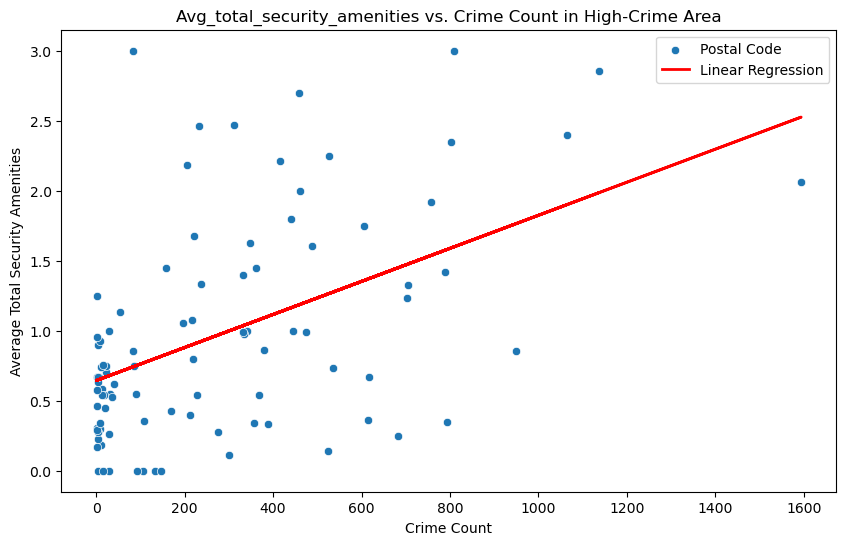

In [86]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
# Perform Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg_score = lin_reg.score(X_test, y_test)

# Print model scores
print("Linear Regression R^2 Score:", lin_reg_score)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='crime_count', y='avg_total_security_amenities', data=filtered_data, label='Postal Code')
plt.plot(X['crime_count'], lin_reg.predict(X), color='red', label='Linear Regression', linewidth=2)
plt.title('Avg_total_security_amenities vs. Crime Count in High-Crime Area')
plt.xlabel('Crime Count')
plt.ylabel('Average Total Security Amenities')
plt.legend()
plt.show()

#### Bar Chart: Distribution of Amenities Across Crime Levels

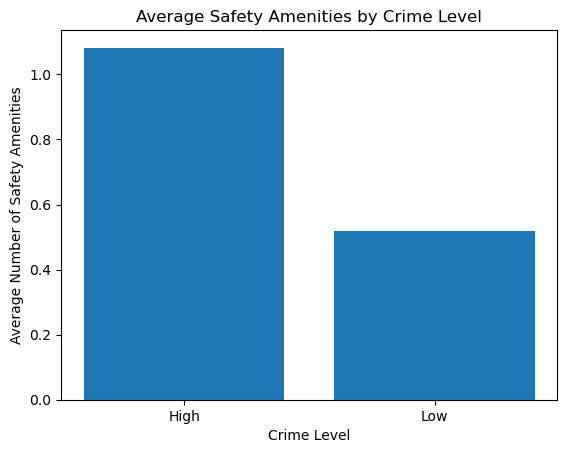

In [87]:
import matplotlib.pyplot as plt

# Group data by crime level (e.g., low/high crime based on median)
merged_data['crime_level'] = ['High' if x > merged_data['crime_count'].median() else 'Low' for x in merged_data['crime_count']]
amenities_by_crime = merged_data.groupby('crime_level')['avg_total_security_amenities'].mean()

# Plot bar chart
plt.bar(amenities_by_crime.index, amenities_by_crime.values)
plt.title('Average Safety Amenities by Crime Level')
plt.xlabel('Crime Level')
plt.ylabel('Average Number of Safety Amenities')
plt.show()
# amenities_by_crime

#### Pie Chart: Most Common Safety Amenities in High-Crime Areas

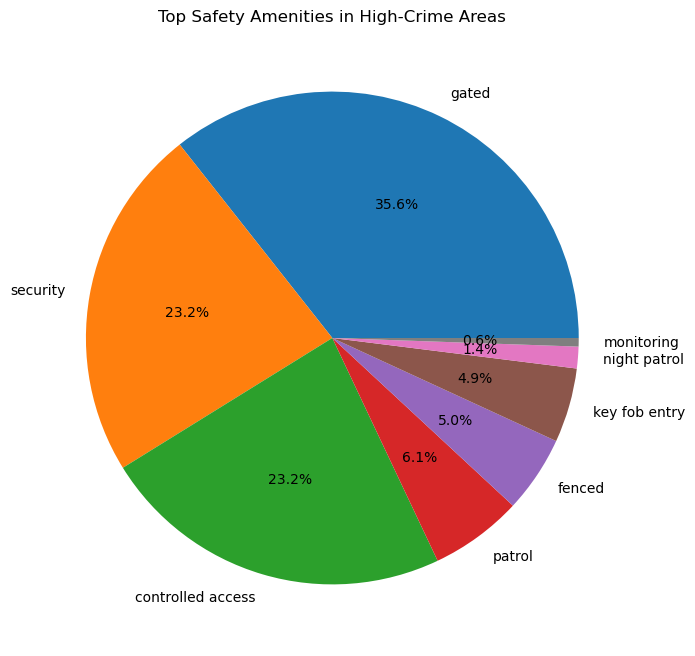

In [88]:
# Sum safety amenities columns
amenity_columns = merged_data.loc[:, 'security':'patrol'].columns.tolist()
high_crime_amenities = high_crime_data[amenity_columns].sum().sort_values(ascending=False)

# Plot pie chart
high_crime_amenities.head(8).plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Top Safety Amenities in High-Crime Areas')
plt.ylabel('')
plt.show()
# high_crime_amenities

## Weighted Crime Scores for Logistic Regression
Test whether areas with higher weighted scores are more likely to have safety-focused amenities.

In [89]:
# Define the crime weights
crime_weights = {
    'violent_crime': 6,
    'human_trafficking': 5,
    'sexual_offense': 5,
    'assault': 4,
    'theft': 3,
    'fraud': 3,
    'public_order': 2,
    'animal_cruelty': 2,
    'other': 1
}

# Add a weighted score column based on the crime category
crime_data['crime_weight'] = crime_data['crime_category'].map(crime_weights)

# Calculate total weighted crime score per postal code
weighted_crime_score = crime_data.groupby('postal_code')['crime_weight'].sum().reset_index()
weighted_crime_score.rename(columns={'crime_weight': 'weighted_crime_score'}, inplace=True)

# Merge weighted crime scores with rental data
merged_data_with_score = pd.merge(merged_data, weighted_crime_score, on='postal_code', how='inner')
print(f"The length of dataframe: {len(weighted_crime_score)}")
print(f"The length of dataframe: {len(merged_data_with_score)}")
merged_data_with_score.columns

The length of dataframe: 113
The length of dataframe: 96


Index(['postal_code', 'avg_total_security_amenities', 'crime_count',
       'high_crime', 'security', 'gated', 'surveillance', 'camera', 'alarm',
       'guard', 'controlled access', 'key fob entry', 'night patrol',
       '24-hour surveillance', 'access control', 'security system',
       'electronic locks', 'monitoring', 'fenced', 'safe', 'locked',
       'protected', 'secure entry', 'patrol', 'crime_level',
       'weighted_crime_score'],
      dtype='object')

In [90]:
# Define high-crime areas based on the median weighted score
merged_data_with_score['high_crime'] = (merged_data_with_score['weighted_crime_score'] > merged_data_with_score['weighted_crime_score'].median()).astype(int)
high_crime_data_with_score = merged_data_with_score[merged_data_with_score['high_crime'] == 1]
# Features and target
X = merged_data_with_score[['avg_total_security_amenities']].fillna(0)  # Features
y = merged_data_with_score['high_crime']  # Target

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(f"Coefficient for Total Security Amenities: {log_reg.coef_[0][0]}")
print(f"Intercept: {log_reg.intercept_[0]}")

              precision    recall  f1-score   support

           0       0.71      0.86      0.77        14
           1       0.83      0.67      0.74        15

    accuracy                           0.76        29
   macro avg       0.77      0.76      0.76        29
weighted avg       0.77      0.76      0.76        29

Coefficient for Total Security Amenities: 1.2067320131455477
Intercept: -1.160037550773161


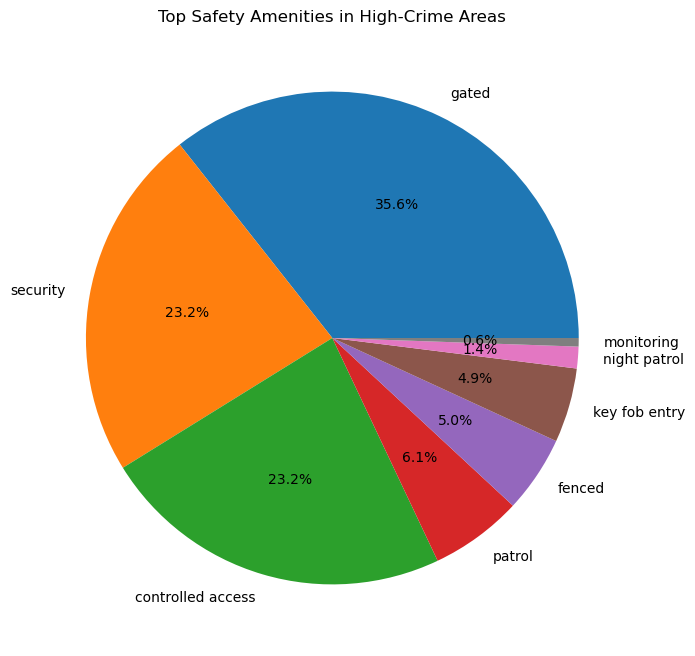

gated                   753
controlled access       557
security                523
patrol                  152
key fob entry           120
fenced                   95
night patrol             36
monitoring               17
surveillance             11
safe                      3
camera                    2
access control            2
alarm                     1
electronic locks          1
guard                     0
24-hour surveillance      0
security system           0
locked                    0
protected                 0
secure entry              0
dtype: int64

In [92]:
# Sum safety amenities columns
amenity_columns = merged_data.loc[:, 'security':'patrol'].columns.tolist()
high_crime_with_score_amenities = high_crime_data_with_score[amenity_columns].sum().sort_values(ascending=False)

# Plot pie chart
high_crime_amenities.head(8).plot.pie(autopct='%1.1f%%', figsize=(8, 8), title='Top Safety Amenities in High-Crime Areas')
plt.ylabel('')
plt.show()
high_crime_with_score_amenities

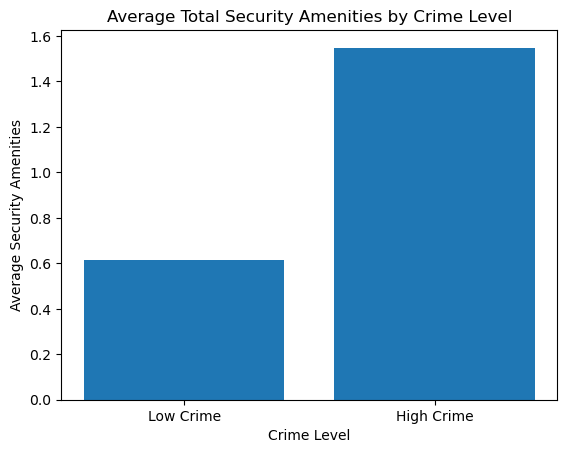

In [101]:
avg_amenities = merged_data_with_score.groupby('high_crime')['avg_total_security_amenities'].mean()

# Plot
plt.bar(['Low Crime', 'High Crime'], avg_amenities)
plt.title('Average Total Security Amenities by Crime Level')
plt.ylabel('Average Security Amenities')
plt.xlabel('Crime Level')
plt.show()

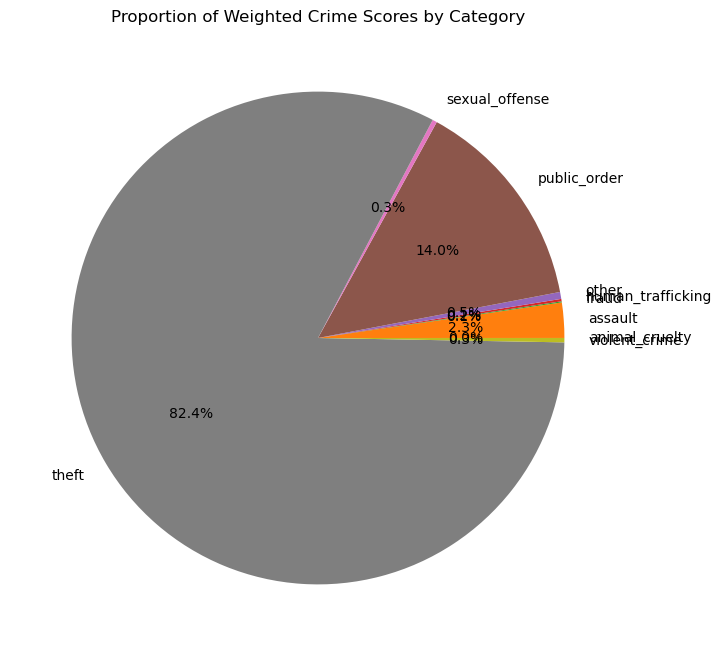

In [94]:
# Calculate the total weighted score by category
weighted_crime_by_category = crime_data.groupby('crime_category')['crime_weight'].sum()

# Plot the pie chart
plt.figure(figsize=(8, 8))
weighted_crime_by_category.plot.pie(
    autopct='%1.1f%%', 
    title='Proportion of Weighted Crime Scores by Category',
    ylabel=''  # Hides the default ylabel
)
plt.show()

#### Try more Random Forest Classifier with more features (ttl_amenities, crime_score, crime_category)

In [95]:
# One-hot encode the crime_category column
crime_category_encoded = pd.get_dummies(crime_data['crime_category'], prefix='crime')

# Aggregate one-hot encoded categories by postal code
crime_category_features = crime_data[['postal_code']].join(crime_category_encoded)
crime_category_aggregated = crime_category_features.groupby('postal_code').sum().reset_index()

# Merge the one-hot encoded features with merged_data
merged_data_with_score = pd.merge(merged_data_with_score, crime_category_aggregated, on='postal_code', how='inner')
# print(f"The length of the dataframe: {len(merged_data_with_score)}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Define the features and target
# features = ['avg_total_security_amenities', 'weighted_crime_score'] + list(crime_category_encoded) + amenity_columns
features = ['avg_total_security_amenities'] + amenity_columns
X = merged_data_with_score[features].fillna(0)  # Include the new features
y = merged_data_with_score['high_crime']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
# print(len(X_train))
# print(len(X_test))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.80      0.92      0.86        13

    accuracy                           0.86        29
   macro avg       0.86      0.87      0.86        29
weighted avg       0.87      0.86      0.86        29

Coefficient for Total Security Amenities: 1.2067320131455477
Intercept: -1.160037550773161


##### Analyze feature importance

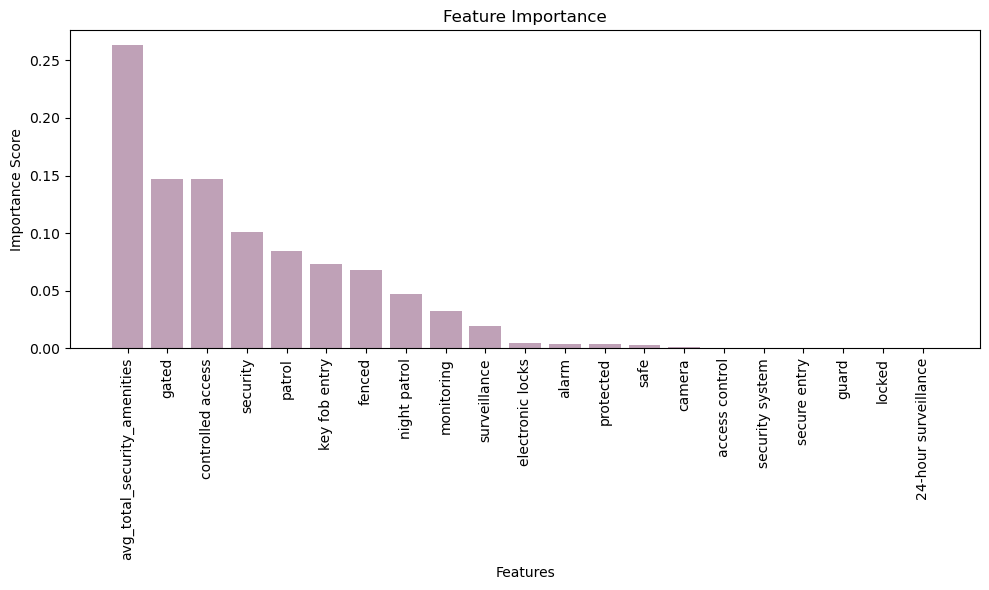

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = np.array(features)[indices]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(features_sorted)), importances[indices], color='#BFA1B7')
plt.xticks(range(len(features_sorted)), features_sorted, rotation=90)
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

### Answer the question: What specific crime types (e.g., theft, assault) drive the need for certain amenities?

In [99]:
# Assume `crime_weights` is a dictionary of crime category weights
crime_weights = {
    'violent_crime': 6,
    'human_trafficking': 5,
    'sexual_offense': 5,
    'assault': 4,
    'theft': 3,
    'fraud': 3,
    'public_order': 2,
    'animal_cruelty': 2,
    'other': 1
}

# Add a weighted score column based on the crime category
crime_data['weighted_score'] = crime_data['crime_category'].map(crime_weights)


# Group by postal code and crime category, and calculate total weighted scores
weighted_crime = crime_data.groupby(['postal_code', 'crime_category'])['weighted_score'].sum().reset_index()

weighted_crime = pd.merge(weighted_crime, merged_data_with_score, on='postal_code', how='left')
weighted_crime

,postal_code,crime_category,weighted_score,avg_total_security_amenities,crime_count,high_crime,security,gated,surveillance,camera,...,weighted_crime_score,crime_animal_cruelty,crime_assault,crime_fraud,crime_human_trafficking,crime_other,crime_public_order,crime_sexual_offense,crime_theft,crime_violent_crime
0,90001.0,assault,4,0.000000,106.0,0.0,0.0,0.0,0.0,0.0,...,311.0,0.0,1.0,0.0,0.0,1.0,6.0,0.0,98.0,0.0
1,90001.0,other,1,0.000000,106.0,0.0,0.0,0.0,0.0,0.0,...,311.0,0.0,1.0,0.0,0.0,1.0,6.0,0.0,98.0,0.0
2,90001.0,public_order,12,0.000000,106.0,0.0,0.0,0.0,0.0,0.0,...,311.0,0.0,1.0,0.0,0.0,1.0,6.0,0.0,98.0,0.0
3,90001.0,theft,294,0.000000,106.0,0.0,0.0,0.0,0.0,0.0,...,311.0,0.0,1.0,0.0,0.0,1.0,6.0,0.0,98.0,0.0
4,90002.0,assault,28,0.333333,389.0,1.0,0.0,0.0,0.0,0.0,...,1137.0,0.0,7.0,0.0,0.0,4.0,40.0,1.0,334.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,91505.0,other,1,0.339286,8.0,0.0,2.0,8.0,0.0,0.0,...,21.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,0.0
417,91505.0,public_order,2,0.339286,8.0,0.0,2.0,8.0,0.0,0.0,...,21.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,0.0
418,91505.0,theft,18,0.339286,8.0,0.0,2.0,8.0,0.0,0.0,...,21.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,0.0
419,91522.0,assault,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Group crimes by type and calculate the average number of amenities for each crime type
crime_amenities = weighted_crime.groupby('crime_category')[amenity_columns].mean()
crime_amenities

,security,gated,surveillance,camera,alarm,guard,controlled access,key fob entry,night patrol,24-hour surveillance,access control,security system,electronic locks,monitoring,fenced,safe,locked,protected,secure entry,patrol
crime_category,,,,,,,,,,,,,,,,,,,,
animal_cruelty,6.000000,12.000000,0.000000,0.000000,0.000000,0.0,18.000000,4.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,6.000000
assault,9.557377,13.540984,0.180328,0.032787,0.016393,0.0,9.754098,2.180328,0.590164,0.0,0.032787,0.0,0.032787,0.213115,1.754098,0.049180,0.0,0.000000,0.016393,2.606557
fraud,5.375000,9.000000,0.000000,0.000000,0.000000,0.0,7.750000,2.250000,1.000000,0.0,0.000000,0.0,0.000000,0.000000,1.250000,0.000000,0.0,0.000000,0.000000,3.250000
human_trafficking,12.666667,13.333333,0.000000,0.111111,0.000000,0.0,13.444444,3.666667,0.333333,0.0,0.000000,0.0,0.000000,0.333333,2.222222,0.000000,0.0,0.000000,0.000000,3.222222
other,9.217391,13.478261,0.159420,0.028986,0.014493,0.0,9.362319,2.086957,0.579710,0.0,0.028986,0.0,0.028986,0.188406,1.753623,0.043478,0.0,0.000000,0.014493,2.492754
public_order,8.500000,12.767442,0.139535,0.034884,0.011628,0.0,8.500000,1.813953,0.488372,0.0,0.023256,0.0,0.023256,0.209302,1.790698,0.034884,0.0,0.011628,0.011628,2.220930
sexual_offense,13.777778,17.222222,0.111111,0.055556,0.000000,0.0,14.388889,3.333333,0.777778,0.0,0.055556,0.0,0.055556,0.333333,2.666667,0.055556,0.0,0.000000,0.000000,3.722222
theft,7.956989,12.172043,0.129032,0.032258,0.021505,0.0,8.010753,1.698925,0.494624,0.0,0.021505,0.0,0.021505,0.182796,1.698925,0.032258,0.0,0.010753,0.010753,2.107527
violent_crime,4.952381,7.619048,0.142857,0.000000,0.000000,0.0,5.238095,1.571429,0.523810,0.0,0.000000,0.0,0.047619,0.238095,1.285714,0.000000,0.0,0.000000,0.000000,2.333333


Top amenities for animal_cruelty:
controlled access    18.0
gated                12.0
security              6.0
patrol                6.0
key fob entry         4.0
Name: animal_cruelty, dtype: float64


Top amenities for assault:
gated                13.540984
controlled access     9.754098
security              9.557377
patrol                2.606557
key fob entry         2.180328
Name: assault, dtype: float64


Top amenities for fraud:
gated                9.000
controlled access    7.750
security             5.375
patrol               3.250
key fob entry        2.250
Name: fraud, dtype: float64


Top amenities for human_trafficking:
controlled access    13.444444
gated                13.333333
security             12.666667
key fob entry         3.666667
patrol                3.222222
Name: human_trafficking, dtype: float64


Top amenities for other:
gated                13.478261
controlled access     9.362319
security              9.217391
patrol                2.492754
key fob en

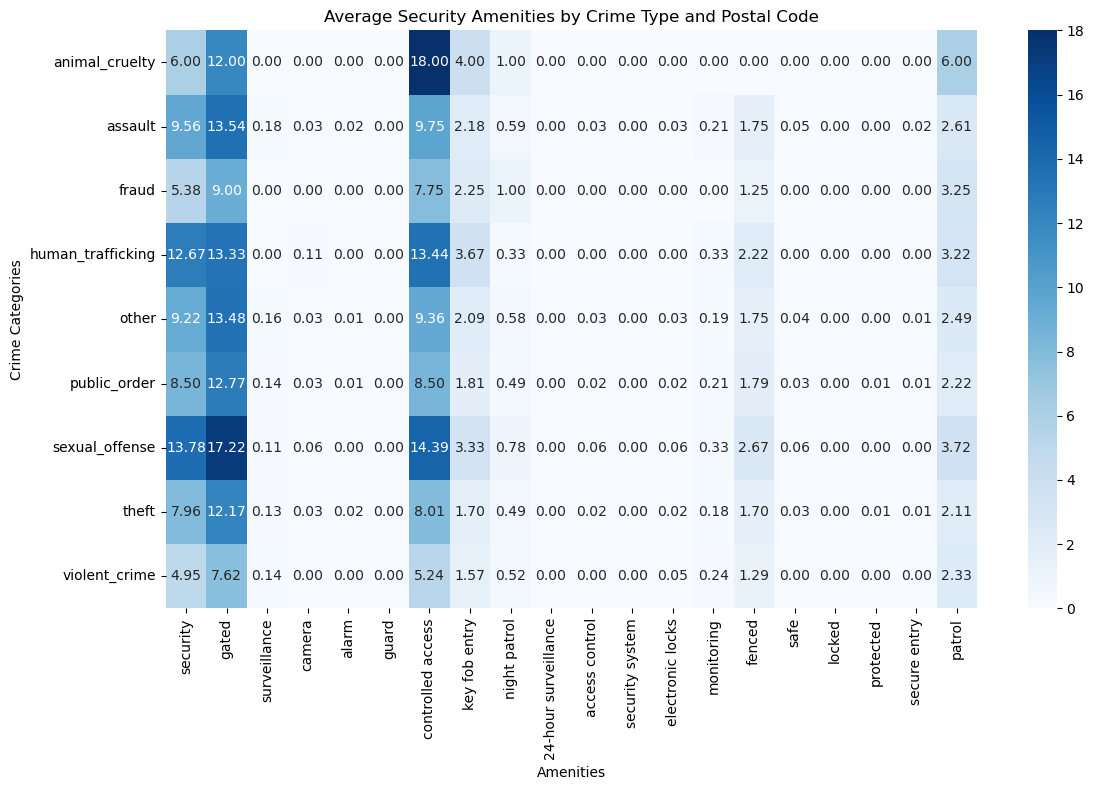

In [102]:
# Rank amenities for each crime category
crime_amenities_ranked = crime_amenities.rank(axis=1, ascending=False)

# Output top amenities for each crime category
for crime_type in crime_amenities.index:
    print(f"Top amenities for {crime_type}:")
    top_amenities = crime_amenities.loc[crime_type].sort_values(ascending=False).head(5)
    print(top_amenities)
    print("\n")

# Visualization: Heatmap of crime categories vs. average amenities
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(crime_amenities, annot=True, fmt=".2f", cmap="Blues")
plt.title("Average Security Amenities by Crime Type and Postal Code")
plt.xlabel("Amenities")
plt.ylabel("Crime Categories")
plt.tight_layout()
plt.show()